In [31]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers ,models


In [36]:
#Global initialization of some imp variables

IMAGE_SIZE = 256
BATCH_SIZE = 32


CHANNELS = 3
Epochs = 40

In [4]:
# Load image
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle = True
)


Found 2152 files belonging to 3 classes.


In [18]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

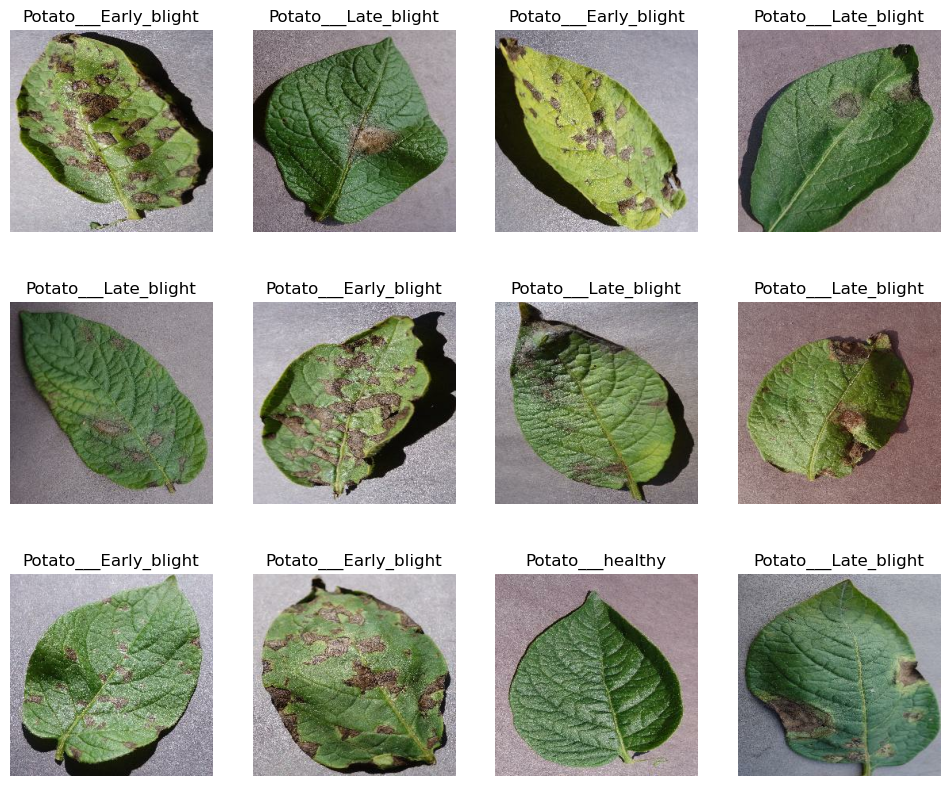

In [25]:
# visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
for  image ,label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        
        plt.title(class_name[label[i]])
        
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis("off")

In [29]:
# train test split

def traintestSplit(df, train = 0.8, test = 0.1, val = 0.1, shuffle =True, shuffling_size = 1000):
    if shuffle:
        df.shuffle(buffer_size= shuffling_size, seed = 10)
    train_ds = df.take(int(train*len(df)))
    val_ds = df.skip(int(train*len(df))).take(int(val*len(df)))
    test_ds=df.skip(int(train*len(df))).skip(int(val*len(df)))
    return train_ds, val_ds, test_ds
 
train_ds, val_ds, test_ds= traintestSplit(dataset)

In [30]:

# caching,shuffle and prefetching the data
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [32]:

# scalling and resizing
resize_rescale= tf.keras.Sequential([
    layers.Rescaling(1.0/255),
    layers.Rescaling(256,256)
    
])



In [34]:
# data augmentation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [40]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)



Kernel Size 1x1:

Example Usage: Used for dimensionality reduction or channel-wise feature transformation without spatial reduction. Often used in network architectures to adjust the number of channels or to introduce non-linearity through activation functions.
Example Applications: Transition layers in dense blocks of DenseNet architectures, feature fusion in skip connections, reducing the number of channels before global pooling in classification networks.
Kernel Size 3x3:

Example Usage: A common choice for capturing local spatial features while maintaining a small receptive field.
Example Applications: Traditional convolutional layers in many CNN architectures, such as VGG, ResNet, and Inception. Effective for learning local patterns like edges, textures, and basic shapes.
Kernel Size 5x5:

Example Usage: Provides a larger receptive field compared to 3x3 kernels, capturing more global spatial information.
Example Applications: Used in deeper layers of CNNs to capture larger patterns or structures in the input data, such as parts of objects or textures.
Kernel Size 7x7:

Example Usage: Offers an even larger receptive field than 5x5 kernels, suitable for capturing very large-scale spatial features.
Example Applications: Typically used in the early layers of CNNs for tasks with very high-resolution input data or when the network needs to capture very large and global features.
Kernel Size 1x3 or 3x1 (and variations):

Example Usage: Useful for capturing features along one dimension while preserving the other. Can be used for capturing horizontal or vertical patterns.
Example Applications: Detecting horizontal or vertical edges, capturing directional information in images, such as in gradient-based feature extraction.
Kernel Size NxN, where N > 7:

Example Usage: Rarely used due to the computational cost and memory requirements associated with larger kernel sizes. However, they can capture extremely large-scale features.
Example Applications: Specialized tasks requiring very large receptive fields or when the input data has very high resolution, such as satellite imagery analysis or medical imaging tasks.
These are just a few examples of kernel sizes and their typical usage scenarios. The choice of kernel size depends on factors such as the characteristics of the input data, the complexity of the task, computational resources, and architectural preferences. Experimentation and validation on specific datasets are crucial for determining the optimal kernel size for a given CNN architecture.

In [46]:
model = tf.keras.Sequential([resize_rescale,
                            data_aug,
                            layers.Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu', input_shape = input_shape),
                            layers.MaxPool2D(2,2), #256/2 = 128
                            layers.Conv2D(64, (3,3), activation='relu'), #128 -3 =125
                            layers.MaxPool2D(2,2), #127/2 = 62
                            layers.Conv2D(128, (3,3), activation='relu'), #63 -3 =60
                            layers.MaxPool2D(2,2), #60/2 = 30
                            layers.Conv2D(64, (3,3), activation='relu'), #30+1-3 = 28
                            layers.MaxPool2D(2,2), #28/2 = 14
                            layers.Conv2D(64, (3,3), activation='relu'), #14+1-3 = 12
                            layers.MaxPool2D(2,2), #12/2 = 6
                            layers.Conv2D(64, (3,3), activation='relu'), #6+1-3 = 4
                            layers.MaxPool2D(2,2), #4/2 = 2*2*64 = 256
                            layers.Flatten(),
                            layers.Dense(128,activation = 'relu'),
                            layers.Dense(64, activation = 'relu'),
                            layers.Dense(3, activation = 'softmax')])
model.build(input_shape = input_shape)

In [47]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (32, 254, 254, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (32, 127, 127, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (32, 125, 125, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (32, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (32, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (32, 28, 28, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,579 (1.04 MB)

 Trainable params: 272,579 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [ ]:
history = model.fit(
train_ds, epochs = Epochs, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 816ms/step - accuracy: 0.4374 - loss: 4.3734 - val_accuracy: 0.4531 - val_loss: 0.9312
Epoch 2/40
12/54 ━━━━━━━━━━━━━━━━━━━━ 27s 662ms/step - accuracy: 0.4588 - loss: 0.8845